In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sn
from matplotlib import pyplot as plt
import statsmodels.api as sm
from pylab import rcParams

In [2]:
#Read the csv file
data=pd.read_csv('data2.csv',parse_dates=['mkt_datetime'])

In [3]:
#Variables for training
cols = list(data)[0:13]
df=data[cols]
df2=df.copy()
df2.set_index('mkt_datetime', inplace=True)

In [4]:
# df['month']= df['mkt_datetime'].apply(lambda x: x.month)
# plt.figure(figsize=(14,5))
# sn.boxplot(x="month", y="ont_ene", data=df)
# plt.xlabel('month')
# plt.title('Box plot of Monthly ont_ene')
# sn.despine(left=True)
# plt.tight_layout()

In [5]:
# corr = df.corr()
# corr.style.background_gradient()

In [6]:
df.set_index('mkt_datetime', inplace=True)

In [7]:
# # Resampling data month-wise and week-wise
# monthly_avg_price = df['ont_ene'].resample('MS').mean()
# weekly_avg_price = df['ont_ene'].resample('W').mean()

In [8]:
# rcParams['figure.figsize']=6,2
# ts=monthly_avg_price.resample('D')
# tsint = ts.interpolate(method='cubic')
# tsint.plot()
# plt.title('Average ont_ene by month')
# plt.show()

In [9]:
# rcParams['figure.figsize']=12,4
# ts=weekly_avg_price.resample('D')
# tsint = ts.interpolate(method='cubic')
# tsint.plot()
# plt.title('Average ont_ene by week')
# plt.show()

In [10]:
# rcParams['figure.figsize'] = 18, 8
# decomposition = sm.tsa.seasonal_decompose(monthly_avg_price, model='additive')
# fig = decomposition.plot()
# plt.show()

In [11]:
# groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
# i = 1
# # plot each column
# values=uni_df.values
# plt.figure(figsize=(14, 10))
# for group in groups:
# 	plt.subplot(len(groups), 1, i)
# 	plt.plot(values[:1000, group])
# 	plt.title(uni_df.columns[group], y=0.5, loc='right')
# 	i += 1
# plt.show()

In [12]:
# normalize the data_set 
sc = MinMaxScaler(feature_range = (0, 1))
df_scaled = sc.fit_transform(df2)

In [13]:
# split into train and test sets
train_size=(365+366)*24  # 2020 - 2021 dataset as training set
test_size = len(df2) - train_size
train_df, test_df = df_scaled[0:train_size,:], df_scaled[train_size:len(df2),:]

In [14]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), :]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 11])
    return np.array(data_x), np.array(data_y)

In [15]:
# # reshape into X=t and Y=t+1
# look_back = 48 # past 48 hours data to be used for prediction
# X_train,Y_train,X_test,Ytest = [],[],[],[]
# X_train,Y_train=create_data_set(train,look_back)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
# X_test,Y_test=create_data_set(test,look_back)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

In [16]:
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')
# regressor.summary()

NameError: name 'X_train' is not defined

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 40, batch_size = 24,validation_data=(X_test, Y_test), callbacks=[reduce_lr], shuffle=False)

In [ ]:
# regressor.save('lstm_multi_model_v3')
# regressor = tf.keras.models.load_model('lstm_multi_model_v2')

In [ ]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [17]:
colNames=list(df2)
colName='ont_ene'
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [ ]:
# invert predictions
train_predict = invTransform(sc,train_predict,colName,colNames)
Y_train_inv = invTransform(sc,Y_train,colName,colNames)
test_predict = invTransform(sc,test_predict,colName,colNames)
Y_test_inv = invTransform(sc,Y_test,colName,colNames)

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train_inv, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_inv, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_inv, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_inv, test_predict)))
print('Train R2 Score: ', r2_score(Y_test_inv, test_predict))
print('Test R2 Score: ', r2_score(Y_train_inv, train_predict))

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(16,6))
plt.plot(aa, Y_test_inv[0:180], marker='.', label="actual")
plt.plot(aa, test_predict[0:180], 'r', label="prediction")
# plt.plot(aa, lstm_20[2000:2180], 'green', label="prediction")
plt.tight_layout()
sn.despine(top=True)
# plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step (hour)', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
# d={'Timestamp':data.mkt_datetime[17592:23567],'original':Y_test_inv,'predicted':test_predict}
# price_df=pd.DataFrame(d)

In [ ]:
train.shape

Observations: 8772
Training Observations: 4386
Testing Observations: 4386
Epoch 1/30
181/181 [==============================] - 36s 144ms/step - loss: 0.0737 - val_loss: 0.0805 - lr: 0.0010
Epoch 2/30
181/181 [==============================] - 23s 125ms/step - loss: 0.0632 - val_loss: 0.0693 - lr: 0.0010
Epoch 3/30
181/181 [==============================] - 23s 129ms/step - loss: 0.0556 - val_loss: 0.0595 - lr: 0.0010
Epoch 4/30
181/181 [==============================] - 25s 138ms/step - loss: 0.0507 - val_loss: 0.0582 - lr: 0.0010
Epoch 5/30
181/181 [==============================] - 24s 134ms/step - loss: 0.0474 - val_loss: 0.0575 - lr: 0.0010
Epoch 6/30
181/181 [==============================] - 24s 133ms/step - loss: 0.0454 - val_loss: 0.0532 - lr: 0.0010
Epoch 7/30
181/181 [==============================] - 24s 133ms/step - loss: 0.0429 - val_loss: 0.0519 - lr: 0.0010
Epoch 8/30
181/181 [==============================] - 24s 134ms/step - loss: 0.0412 - val_loss: 0.0512 - lr: 0.001

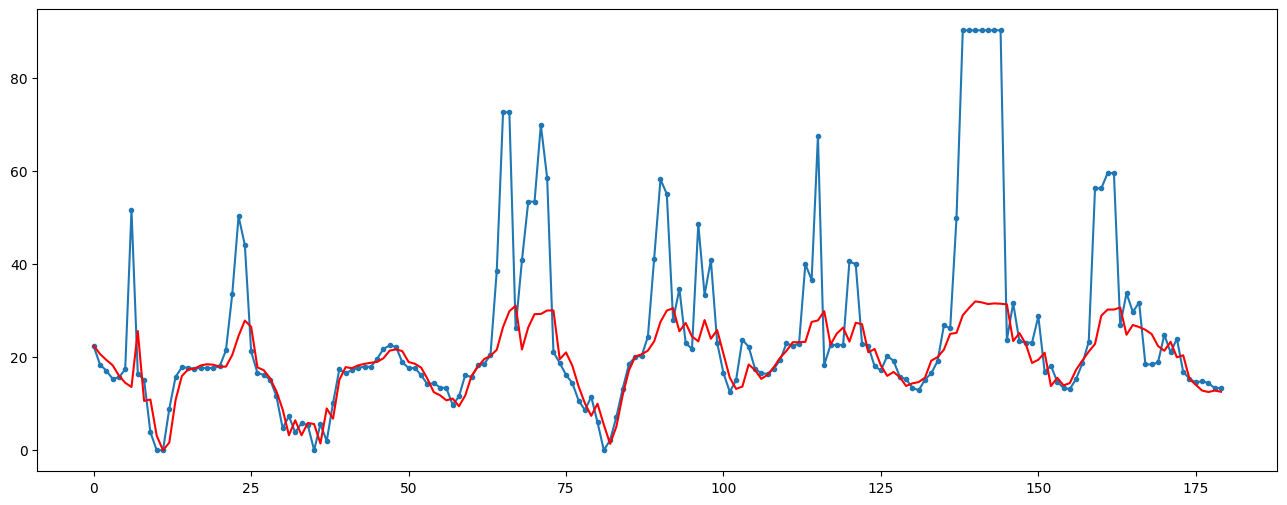

Observations: 13158
Training Observations: 8772
Testing Observations: 4386
Epoch 1/30
364/364 [==============================] - 74s 167ms/step - loss: 0.0742 - val_loss: 0.1141 - lr: 0.0010
Epoch 2/30
364/364 [==============================] - 59s 162ms/step - loss: 0.0581 - val_loss: 0.0951 - lr: 0.0010
Epoch 3/30
364/364 [==============================] - 56s 153ms/step - loss: 0.0515 - val_loss: 0.0825 - lr: 0.0010
Epoch 4/30
364/364 [==============================] - 55s 150ms/step - loss: 0.0480 - val_loss: 0.0683 - lr: 0.0010
Epoch 5/30
364/364 [==============================] - 60s 165ms/step - loss: 0.0438 - val_loss: 0.0617 - lr: 0.0010
Epoch 6/30
364/364 [==============================] - 52s 143ms/step - loss: 0.0417 - val_loss: 0.0562 - lr: 0.0010
Epoch 7/30
364/364 [==============================] - 50s 139ms/step - loss: 0.0405 - val_loss: 0.0650 - lr: 0.0010
Epoch 8/30
364/364 [==============================] - 52s 144ms/step - loss: 0.0398 - val_loss: 0.0610 - lr: 0.00

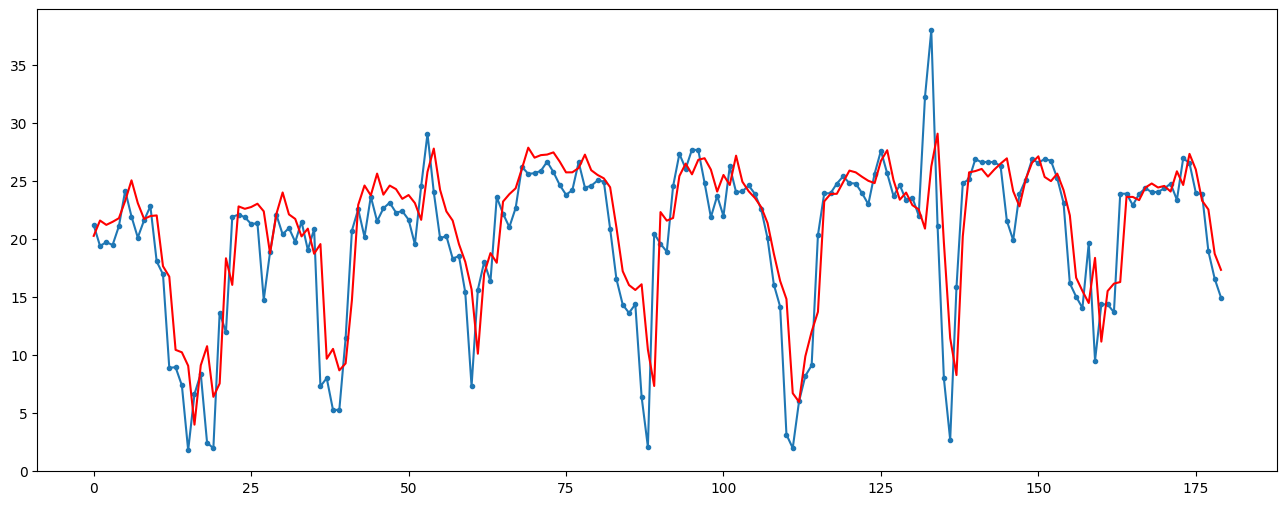

Observations: 17544
Training Observations: 13158
Testing Observations: 4386
Epoch 1/30
547/547 [==============================] - 52s 82ms/step - loss: 0.0773 - val_loss: 0.1219 - lr: 0.0010
Epoch 2/30
547/547 [==============================] - 43s 78ms/step - loss: 0.0600 - val_loss: 0.1044 - lr: 0.0010
Epoch 3/30
547/547 [==============================] - 45s 81ms/step - loss: 0.0533 - val_loss: 0.0928 - lr: 0.0010
Epoch 4/30
547/547 [==============================] - 43s 79ms/step - loss: 0.0500 - val_loss: 0.0890 - lr: 0.0010
Epoch 5/30
547/547 [==============================] - 43s 78ms/step - loss: 0.0475 - val_loss: 0.0840 - lr: 0.0010
Epoch 6/30
547/547 [==============================] - 44s 80ms/step - loss: 0.0455 - val_loss: 0.0787 - lr: 0.0010
Epoch 7/30
547/547 [==============================] - 43s 79ms/step - loss: 0.0457 - val_loss: 0.0767 - lr: 0.0010
Epoch 8/30
547/547 [==============================] - 44s 80ms/step - loss: 0.0446 - val_loss: 0.0773 - lr: 0.0010
Epoc

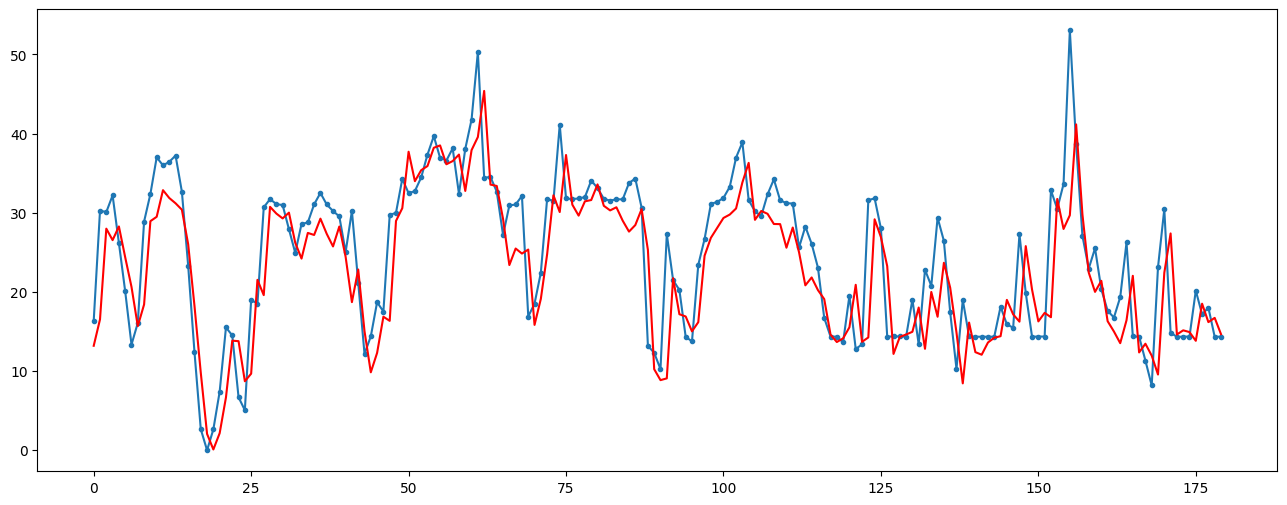

In [18]:
splits = TimeSeriesSplit(n_splits=3)
index = 0
for train_index, test_index in splits.split(train_df):
    train = train_df[train_index]
    test = train_df[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    index += 1
    # reshape into X=t and Y=t+1
    look_back = 48 # past 48 hours data to be used for prediction
    X_train,Y_train,X_test,Ytest = [],[],[],[]
    X_train,Y_train=create_data_set(train,look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_test,Y_test=create_data_set(test,look_back)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))
    regressor = Sequential()

    regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 60, return_sequences = True))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 60))
    regressor.add(Dropout(0.2))

    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
    history =regressor.fit(X_train, Y_train, epochs = 30, batch_size = 24,validation_data=(X_test, Y_test), callbacks=[reduce_lr], shuffle=False)
    
    train_predict = regressor.predict(X_train)
    test_predict = regressor.predict(X_test)
    
    # invert predictions
    train_predict = invTransform(sc,train_predict,colName,colNames)
    Y_train_inv = invTransform(sc,Y_train,colName,colNames)
    test_predict = invTransform(sc,test_predict,colName,colNames)
    Y_test_inv = invTransform(sc,Y_test,colName,colNames)
    # report performance
    print(index,'Train Mean Absolute Error:', mean_absolute_error(Y_train_inv, train_predict))
    print(index,'Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_inv, train_predict)))
    print(index,'Test Mean Absolute Error:', mean_absolute_error(Y_test_inv, test_predict))
    print(index,'Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_inv, test_predict)))
    print('Train R2 Score: ', r2_score(Y_train_inv, train_predict))
    print('Test R2 Score: ', r2_score(Y_test_inv, test_predict))
    aa=[x for x in range(180)]
    plt.figure(figsize=(16,6))
    plt.plot(aa, Y_test_inv[0:180], marker='.', label="actual")
    plt.plot(aa, test_predict[0:180], 'r', label="prediction")
    plt.show()

In [ ]:
print('R2 Score: ', r2_score(Y_test_inv, test_predict))
print('R2 Score: ', r2_score(Y_train_inv, train_predict))

In [ ]:
aa=[x for x in range(180)]
plt.figure(figsize=(16,6))
plt.plot(aa, Y_test_inv[0:180], marker='.', label="actual")
plt.plot(aa, test_predict[0:180], 'r', label="prediction")

In [20]:
# # reshape into X=t and Y=t+1
look_back = 48 # past 48 hours data to be used for prediction
X_test,Ytest = [],[]
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))

In [28]:
test_predict = regressor.predict(X_test)

# invert predictions
test_predict = invTransform(sc,test_predict,colName,colNames)
Y_test_inv = invTransform(sc,Y_test,colName,colNames)
# report performance
print(index,'Train Mean Absolute Error:', mean_absolute_error(Y_train_inv, train_predict))
print(index,'Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_inv, train_predict)))
print(index,'Test Mean Absolute Error:', mean_absolute_error(Y_test_inv, test_predict))
print(index,'Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_inv[:24], test_predict[:24])))
print('Train R2 Score: ', r2_score(Y_train_inv, train_predict))

136/136 [==============================] - 4s 28ms/step
3 Train Mean Absolute Error: 3.5154900110519507
3 Train Root Mean Squared Error: 6.089887817516871
3 Test Mean Absolute Error: 14.659853456031179


ValueError: Found input variables with inconsistent numbers of samples: [144, 24]

In [29]:
print(index,'Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_inv[:24], test_predict[:24])))

3 Test Root Mean Squared Error: 9.65210557159567


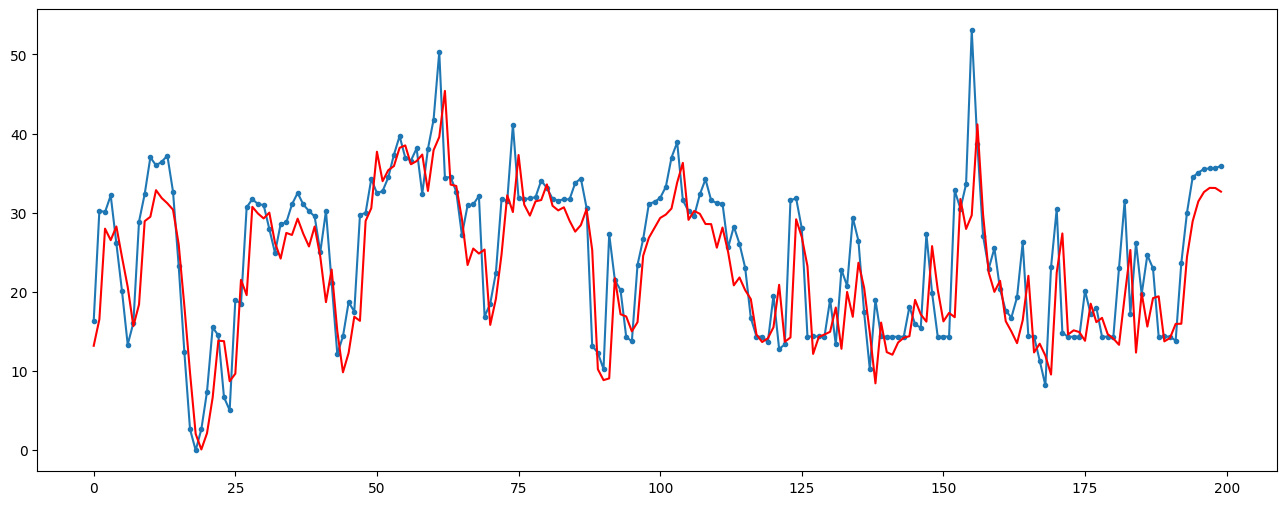

In [23]:
aa=[x for x in range(200)]
plt.figure(figsize=(16,6))
plt.plot(aa, Y_test_inv[0:200], marker='.', label="actual")
plt.plot(aa, test_predict[0:200], 'r', label="prediction")
plt.show()

In [24]:
regressor = Sequential()

regressor.add(GRU(units = 60, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(GRU(units = 60, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(GRU(units = 60))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error')
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 48, 60)            13320     
                                                                 
 dropout_9 (Dropout)         (None, 48, 60)            0         
                                                                 
 gru_1 (GRU)                 (None, 48, 60)            21960     
                                                                 
 dropout_10 (Dropout)        (None, 48, 60)            0         
                                                                 
 gru_2 (GRU)                 (None, 60)                21960     
                                                                 
 dropout_11 (Dropout)        (None, 60)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 40, batch_size = 24,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/40
547/547 [==============================] - 72s 113ms/step - loss: 0.0663 - val_loss: 0.0925 - lr: 0.0010
Epoch 2/40
547/547 [==============================] - 65s 118ms/step - loss: 0.0524 - val_loss: 0.0807 - lr: 0.0010
Epoch 3/40
173/547 [========>.....................] - ETA: 40s - loss: 0.0430

KeyboardInterrupt: 

In [ ]:
regressor.save('gru_multi_model_v2')

In [ ]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [ ]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [ ]:
colNames=list(uni_df)
colName='ont_ene'

In [ ]:
# invert predictions
train_predict = invTransform(sc,train_predict,colName,colNames)
Y_train_inv = invTransform(sc,Y_train,colName,colNames)
test_predict = invTransform(sc,test_predict,colName,colNames)
Y_test_inv = invTransform(sc,Y_test,colName,colNames)

In [ ]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train_inv, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train_inv, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_inv, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_inv, test_predict)))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(16,6))
plt.plot(aa, Y_test_inv[1000:1180], marker='.', label="actual")
plt.plot(aa, test_predict[1000:1180], 'r', label="prediction")
plt.tight_layout()
sn.despine(top=True)
# plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step (hour)', size=15)
plt.legend(fontsize=15)
plt.show();

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
print('R2 Score: ', r2_score(Y_test_inv, test_predict))